**Topic modelling for news articles**

In [1]:
#%pip install gensim
#%pip install pyLDAvis
#%pip install --upgrade numexpr
#%pip install --upgrade bottleneck
#%pip install openpyxl
import pandas as pd
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim_models
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alicjadorobis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alicjadorobis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
#load the data into a dataframe
df = pd.read_excel('ride_sharing_data_full.xlsx')

display(df)

#removing line spacing and 'at' symbols
df = df.replace('\n',' ', regex=True)
df = df.replace('\xa0',' ', regex=True)

# store text in a new list
article_text = df['Text'].to_list()

# check the text 
#article_text


,name,place_id,location_link,reviews_total,rating,review_text,review_rating,review_datetime_utc,reviews_per_score_1,reviews_per_score_2,reviews_per_score_3,reviews_per_score_4,reviews_per_score_5,review_text_english_googletrans
0,OV-Fiets,ChIJCwHQg38JxkcRJeVtM9mPCnM,https://www.google.com/maps/place/OV-Fiets/@52...,33,3.3,I had a flat tire and they refused to fix it b...,2,10/13/2023 09:26:27,12,1,1,3,16,I had a flat tire and they refused to fix it b...
1,OV-Fiets,ChIJCwHQg38JxkcRJeVtM9mPCnM,https://www.google.com/maps/place/OV-Fiets/@52...,33,3.3,"These guys were super sweet to me, fixed my bi...",5,12/04/2017 09:58:35,12,1,1,3,16,"These guys were super sweet to me, fixed my bi..."
2,OV-Fiets,ChIJCwHQg38JxkcRJeVtM9mPCnM,https://www.google.com/maps/place/OV-Fiets/@52...,33,3.3,This place used to be good... Now it is anothe...,1,08/01/2018 07:57:28,12,1,1,3,16,This place used to be good... Now it is anothe...
3,OV-Fiets,ChIJCwHQg38JxkcRJeVtM9mPCnM,https://www.google.com/maps/place/OV-Fiets/@52...,33,3.3,"Opens at 5:30, but do not count on that.",1,09/07/2023 01:37:13,12,1,1,3,16,"Opens at 5:30, but do not count on that."
4,OV-Fiets,ChIJCwHQg38JxkcRJeVtM9mPCnM,https://www.google.com/maps/place/OV-Fiets/@52...,33,3.3,This place also contains a bicycle repairshop ...,5,03/12/2022 10:13:34,12,1,1,3,16,This place also contains a bicycle repairshop ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1210,MOBIHUB P+R Scheepvaartkwartier,ChIJ5_ZVzPwzxEcRnORjwSzG0fU,https://www.google.com/maps/place/MOBIHUB+P%2B...,65,4.6,NaN,5,06/08/2023 09:44:06,0,1,5,15,44,into
1211,MOBIHUB P+R Scheepvaartkwartier,ChIJ5_ZVzPwzxEcRnORjwSzG0fU,https://www.google.com/maps/place/MOBIHUB+P%2B...,65,4.6,NaN,5,06/14/2023 07:53:07,0,1,5,15,44,into
1212,MOBIHUB P+R Scheepvaartkwartier,ChIJ5_ZVzPwzxEcRnORjwSzG0fU,https://www.google.com/maps/place/MOBIHUB+P%2B...,65,4.6,NaN,5,02/25/2023 07:27:54,0,1,5,15,44,into
1213,MOBIHUB P+R Scheepvaartkwartier,ChIJ5_ZVzPwzxEcRnORjwSzG0fU,https://www.google.com/maps/place/MOBIHUB+P%2B...,65,4.6,NaN,5,03/07/2023 13:43:09,0,1,5,15,44,into


In [4]:
import string
from nltk.tokenize import word_tokenize
#custom stopwords added after viewing the initial visualisation
custom_stopwords = ['also', 'said', 'one', 'per', 'get', 'could', 'would', 'ev', 'u', 'make', 'av', 'It', 'The', 'This', 'say', 'In', 'I', 'http','year']
def preprocess(text):
    stop_words = set(stopwords.words('english')).union(set(custom_stopwords or []))  # adding the custom stopwords and english
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    
    return [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word.isalpha()]   #substitute tokens for text.lower().split() if nto working


processed_texts = [preprocess(text) for text in article_text]

In [5]:
# creating the corpus
dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]
corpus 

[[(0, 1),
  (1, 1),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 4),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 2),
  (20, 1)],
 [(3, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1)],
 [(1, 1),
  (3, 4),
  (10, 1),
  (13, 1),
  (14, 1),
  (17, 1),
  (30, 1),
  (36, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 2),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 2),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 2),
  (65, 2),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 2),
  (76, 1),
  (77, 5),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),

In [31]:
from gensim.models import CoherenceModel

# the higher the coherence score the better choice of the number of topics
coherence__perplexity_list = []

for i in range(1,40):
    lda_model = LdaModel(corpus, num_topics=i, id2word=dictionary, passes=15)

    coherence_model = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence() #coherence
    perplexity = lda_model.log_perplexity(corpus) #perplexity

    coherence__perplexity_list.append((i, coherence_score, perplexity)) #adding to a list
    print(f"Number of Topics: {i}, Coherence Score: {coherence_score}, Perplexity: {perplexity}")



Number of Topics: 1, Coherence Score: 0.2614579573235585, Perplexity: -8.073963965081768
Number of Topics: 2, Coherence Score: 0.3073841438907725, Perplexity: -8.024145412323339
Number of Topics: 3, Coherence Score: 0.3092896776867459, Perplexity: -8.03942836038024
Number of Topics: 4, Coherence Score: 0.3389805106140678, Perplexity: -8.02118718905222
Number of Topics: 5, Coherence Score: 0.3223028835046137, Perplexity: -8.037286729720007
Number of Topics: 6, Coherence Score: 0.31391171998716966, Perplexity: -8.054418066304185
Number of Topics: 7, Coherence Score: 0.3458944546557309, Perplexity: -8.03252467476815
Number of Topics: 8, Coherence Score: 0.32226477083575505, Perplexity: -8.043850235635409
Number of Topics: 9, Coherence Score: 0.3536718162055041, Perplexity: -8.051604682793776
Number of Topics: 10, Coherence Score: 0.33169140463495456, Perplexity: -8.058362927548227
Number of Topics: 11, Coherence Score: 0.33507994674579383, Perplexity: -8.052595182686623
Number of Topics: 

In [32]:
score_result_df = pd.DataFrame(coherence__perplexity_list, columns=['Num_Topics', 'Coherence_Score', 'Perplexity'])
display(score_result_df)
score_result_df.to_csv('Coherence_perplexity_article.csv')

,Num_Topics,Coherence_Score,Perplexity
0,1,0.261458,-8.073964
1,2,0.307384,-8.024145
2,3,0.309290,-8.039428
3,4,0.338981,-8.021187
4,5,0.322303,-8.037287
5,6,0.313912,-8.054418
6,7,0.345894,-8.032525
7,8,0.322265,-8.043850
8,9,0.353672,-8.051605
9,10,0.331691,-8.058363


In [71]:
# reading the csv
df_coherence_perplexity = pd.read_csv('Coherence_perplexity_article.csv')
display(df_coherence_perplexity)

,Unnamed: 0,Num_Topics,Coherence_Score,Perplexity
0,0,1,0.261458,-8.073964
1,1,2,0.307384,-8.024145
2,2,3,0.309290,-8.039428
3,3,4,0.338981,-8.021187
4,4,5,0.322303,-8.037287
5,5,6,0.313912,-8.054418
6,6,7,0.345894,-8.032525
7,7,8,0.322265,-8.043850
8,8,9,0.353672,-8.051605
9,9,10,0.331691,-8.058363


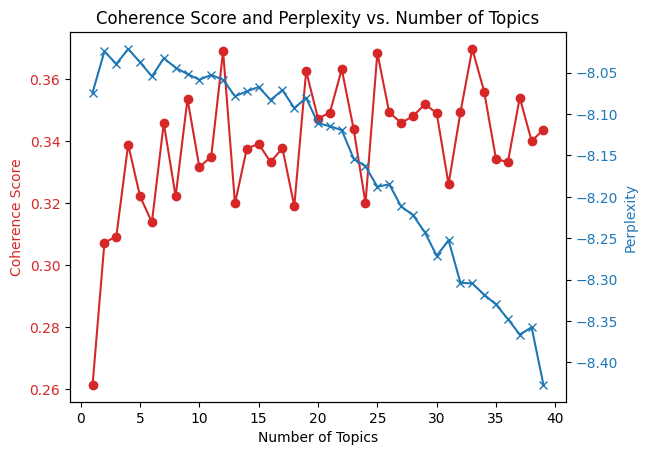

In [72]:

# Plot the results
fig, ax1 = plt.subplots()

# Plot Coherence Score on the first y-axis
color = 'tab:red'
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('Coherence Score', color=color)
ax1.plot(df_coherence_perplexity['Num_Topics'], df_coherence_perplexity['Coherence_Score'], color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis to plot Perplexity
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Perplexity', color=color)
ax2.plot(df_coherence_perplexity['Num_Topics'], df_coherence_perplexity['Perplexity'], color=color, marker='x')
ax2.tick_params(axis='y', labelcolor=color)

# Title and show the plot
plt.title('Coherence Score and Perplexity vs. Number of Topics')
plt.show()

In [6]:
# Apply LDA to the chose number of topics
num_topics = 18  # Change this depending on how many topics you want
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)

In [7]:
# Extract topic distributions for each document 
doc_topics = [lda_model.get_document_topics(bow) for bow in corpus]

In [8]:
# first aticle
print(article_text[0])
# topics distribution within 1st article
print(doc_topics[0])

I had a flat tire and they refused to fix it because it was electric bike. The back row had nothing to do with the electric part since I've only made it electric by changing the front tire myself. I had to walk an hour to find another shop after this. Don't go here if you have electric bike.
[(17, 0.9650174)]


In [55]:
# extract word distribution for each topic
word_topics = lda_model.print_topics()

# word distribution within topics
for idx, topic in word_topics:
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.010*"car" + 0.007*"The" + 0.007*"service" + 0.006*"city" + 0.006*"vehicle" + 0.005*"company" + 0.005*"people" + 0.004*"year" + 0.004*"system" + 0.004*"bike"
Topic: 1 
Words: 0.011*"city" + 0.009*"service" + 0.009*"The" + 0.006*"car" + 0.006*"technology" + 0.005*"vehicle" + 0.005*"people" + 0.004*"smart" + 0.004*"It" + 0.004*"driver"
Topic: 2 
Words: 0.011*"vehicle" + 0.009*"The" + 0.008*"city" + 0.007*"data" + 0.007*"traffic" + 0.005*"car" + 0.005*"service" + 0.005*"technology" + 0.004*"public" + 0.004*"company"
Topic: 3 
Words: 0.009*"vehicle" + 0.008*"car" + 0.008*"The" + 0.006*"company" + 0.006*"service" + 0.005*"new" + 0.005*"mobility" + 0.005*"transportation" + 0.004*"city" + 0.004*"technology"
Topic: 4 
Words: 0.013*"car" + 0.011*"The" + 0.011*"vehicle" + 0.007*"service" + 0.005*"technology" + 0.005*"transportation" + 0.005*"autonomous" + 0.005*"time" + 0.004*"In" + 0.004*"company"
Topic: 5 
Words: 0.009*"The" + 0.008*"car" + 0.006*"technology" + 0.006*"bike" +

In [9]:
# Visualization
import pyLDAvis.gensim_models

In [10]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(vis, 'lda_visualization18.html')